In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib notebook
%config Application.log_level="INFO"

In [3]:
%env TP_ISAE_DATA = /home/fchouteau/repositories/tp_isae/data/

env: TP_ISAE_DATA=/home/fchouteau/repositories/tp_isae/data/


In [4]:
# Import vis
%matplotlib notebook

from khumeia.utils import list_utils
from khumeia import visualisation
from matplotlib import pyplot as plt

In [5]:
# Load data
import json
import os

import khumeia
khumeia.download_eval_data()

[2018-11-12 11:00:41,556][tp-isae][get_data][INFO] Downloading evaluation data
[2018-11-12 11:00:41,556][tp-isae][get_data][INFO] Downloading data from tp_isae_eval_data.tar.gz to /home/fchouteau/repositories/tp_isae/data/
[2018-11-12 11:00:41,557][tp-isae][get_data][INFO] Extracting tar gz
[2018-11-12 11:00:41,919][tp-isae][get_data][INFO] Done. Your data is located here /home/fchouteau/repositories/tp_isae/data/raw



In [6]:
from khumeia.data.collection import SatelliteImagesCollection

RAW_DATA_DIR = os.path.join(os.environ.get("TP_ISAE_DATA"), "raw")
EVAL_DATA_DIR = os.path.join(RAW_DATA_DIR, "eval")

eval_collection = SatelliteImagesCollection.from_path(EVAL_DATA_DIR)

print(eval_collection)

--- Item collection ---
collection_id: eval
Number of items: 3
--- Item description ---
image_id: USGS_DEN
image_file: /home/fchouteau/repositories/tp_isae/data/raw/eval/USGS_DEN.jpg
label_file: /home/fchouteau/repositories/tp_isae/data/raw/eval/USGS_DEN.json
image_shape: (7685, 6205, 3)
number of labels: 52
--- Item description ---
image_id: USGS_LAX
image_file: /home/fchouteau/repositories/tp_isae/data/raw/eval/USGS_LAX.jpg
label_file: /home/fchouteau/repositories/tp_isae/data/raw/eval/USGS_LAX.json
image_shape: (7930, 6689, 3)
number of labels: 92
--- Item description ---
image_id: USGS_MSY
image_file: /home/fchouteau/repositories/tp_isae/data/raw/eval/USGS_MSY.jpg
label_file: /home/fchouteau/repositories/tp_isae/data/raw/eval/USGS_MSY.json
image_shape: (8211, 6514, 3)
number of labels: 47



In [7]:
from khumeia.inference.engine import InferenceEngine
from khumeia.data.sliding_window import SlidingWindow
from khumeia.inference.predictor import Predictor

/home/fchouteau/miniconda3/envs/tp_isae/lib/python3.6/site-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


In [8]:
import random
import numpy as np

class DemoPredictor(Predictor):
    """
    Dummy predictor randomly returning aircraft or background
    """

    def __init__(self, threshold=0.9, batch_size=128):
        self.threshold = threshold
        self.batch_size = batch_size
        self.model = lambda x: "aircraft" if random.random() > threshold else "background"

    def predict(self, tile_data):
        print("Received data of shape {}".format(tile_data.shape))
        return self.model(tile_data)

    def predict_on_batch(self, tiles_data):
        tiles_data = np.asarray(tiles_data)
        print("Received data of shape {}".format(tiles_data.shape))
        return [self.model(tile_data) for tile_data in tiles_data]

In [9]:
predictor = DemoPredictor(threshold=0.75, batch_size=128)

In [10]:
sliding_window = SlidingWindow(
    tile_size=64,
    stride=64,
    discard_background=False,
    padding=0,
    label_assignment_mode="center")

In [11]:
inference_engine = InferenceEngine(items=eval_collection)

In [12]:
results = inference_engine.predict_on_item(eval_collection[0],predictor=predictor, sliding_windows=sliding_window)

[2018-11-12 11:00:42,684][tp-isae][engine][INFO] Generating tiles to predict



[2018-11-12 11:00:43,377][tp-isae][engine][INFO] Generating predicting on item USGS_DEN with 11520 tiles


Received data of shape (128, 64, 64, 3)
Received data of shape (128, 64, 64, 3)
Received data of shape (128, 64, 64, 3)
Received data of shape (128, 64, 64, 3)
Received data of shape (128, 64, 64, 3)
Received data of shape (128, 64, 64, 3)
Received data of shape (128, 64, 64, 3)
Received data of shape (128, 64, 64, 3)
Received data of shape (128, 64, 64, 3)
Received data of shape (128, 64, 64, 3)
Received data of shape (128, 64, 64, 3)
Received data of shape (128, 64, 64, 3)
Received data of shape (128, 64, 64, 3)
Received data of shape (128, 64, 64, 3)
Received data of shape (128, 64, 64, 3)
Received data of shape (128, 64, 64, 3)
Received data of shape (128, 64, 64, 3)
Received data of shape (128, 64, 64, 3)
Received data of shape (128, 64, 64, 3)
Received data of shape (128, 64, 64, 3)
Received data of shape (128, 64, 64, 3)
Received data of shape (128, 64, 64, 3)
Received data of shape (128, 64, 64, 3)
Received data of shape (128, 64, 64, 3)
Received data of shape (128, 64, 64, 3)


<IPython.core.display.Javascript object>


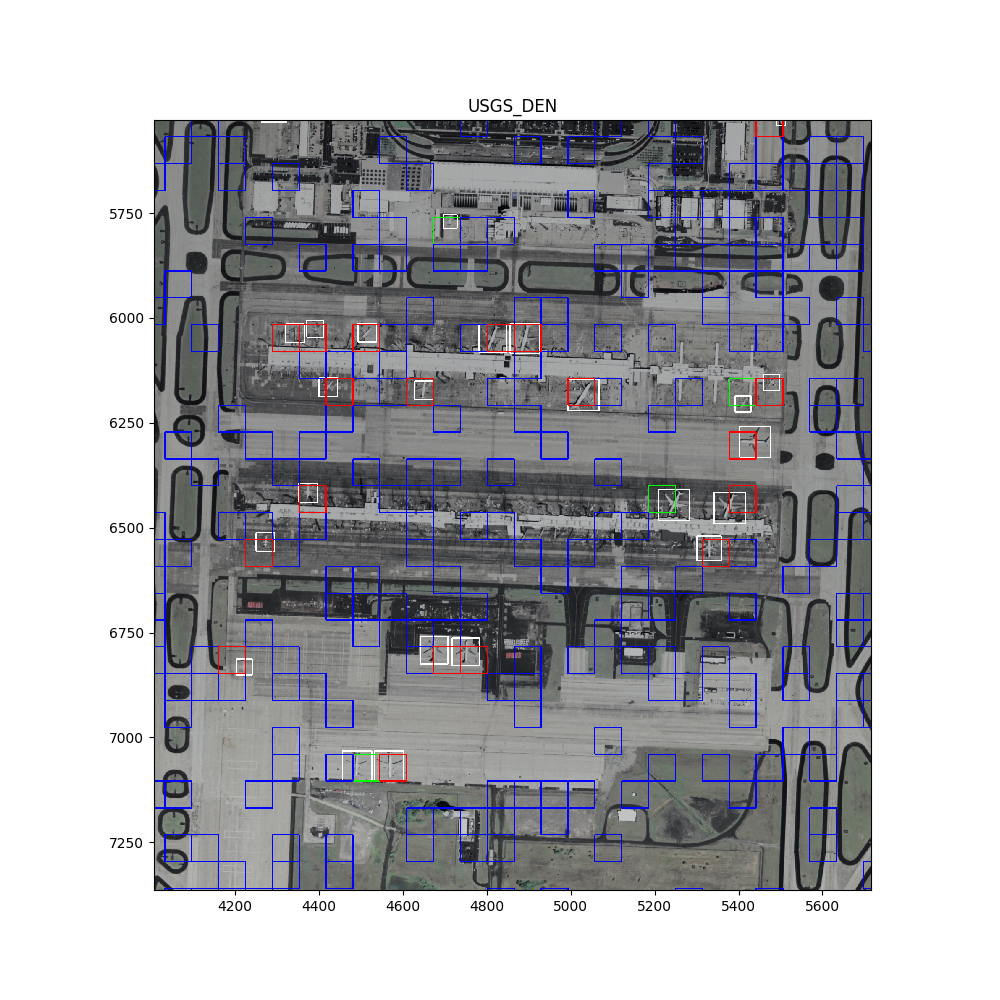

In [13]:
item = eval_collection.items[0]
image = item.image
labels = item.labels

tiles = list(filter(lambda tile: tile.item_id == item.key, results))
true_positives = list(filter(lambda tile: tile.is_true_positive, tiles))
false_positives = list(filter(lambda tile: tile.is_false_positive, tiles))
false_negatives = list(filter(lambda tile: tile.is_false_negative, tiles))

image = visualisation.draw_bboxes_on_image(image, labels, color=(255,255,255))
image = visualisation.draw_bboxes_on_image(image, true_positives, color=(0, 255, 0))
image = visualisation.draw_bboxes_on_image(image, false_positives, color=(0, 0, 255))
image = visualisation.draw_bboxes_on_image(image, false_negatives, color=(255, 0, 0))

plt.figure(figsize=(10, 10))
plt.title(item.image_id)
plt.imshow(image)
plt.show()